In [59]:
import re
import pandas as pd
import numpy as np
import tensorflow as tf
from IPython.display import clear_output
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, hamming_loss, accuracy_score, roc_auc_score, confusion_matrix
from google.colab import drive
from os.path import join
import nltk
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import KFold
import seaborn as sns
from collections import Counter
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

nltk.download("stopwords", quiet=True)

True

In [32]:
drive.mount("/content/drive/", force_remount=False)
DATA_PATH = "/content/drive/My Drive/Colab Notebooks/ML4MDE_Project/"


file = join(DATA_PATH, "dataset.csv")
df = pd.read_csv(file, header=0)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


<hr />
<h2>Data Preprocessing</h2>

In [33]:
contraction_mapping = {
    "ain't": "is not",
    "aren't": "are not",
    "can't": "cannot",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'll": "he will",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "I'd": "I would",
    "I'd've": "I would have",
    "I'll": "I will",
    "I'll've": "I will have",
    "I'm": "I am",
    "I've": "I have",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "this's": "this is",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "here's": "here is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
}

stop_words = set(nltk.corpus.stopwords.words('english'))

def clean_text(text: str):
    to_clean = text.lower()
    to_clean = to_clean.replace('"', '')
    to_clean = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in to_clean.split(" ")])
    to_clean = re.sub("[^a-zA-Z]", " ", to_clean)
    words = [word for word in to_clean.split() if word not in stop_words and len(word) > 1]
    return " ".join(words).strip()

In [34]:
df["comment_text"] = df["comment_text"].apply(clean_text)
X = df["comment_text"].values
y = df[df.columns[2:]].values

<ipython-input-35-52bcbb327fdf>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=counts.values, y=counts.index, palette='viridis')


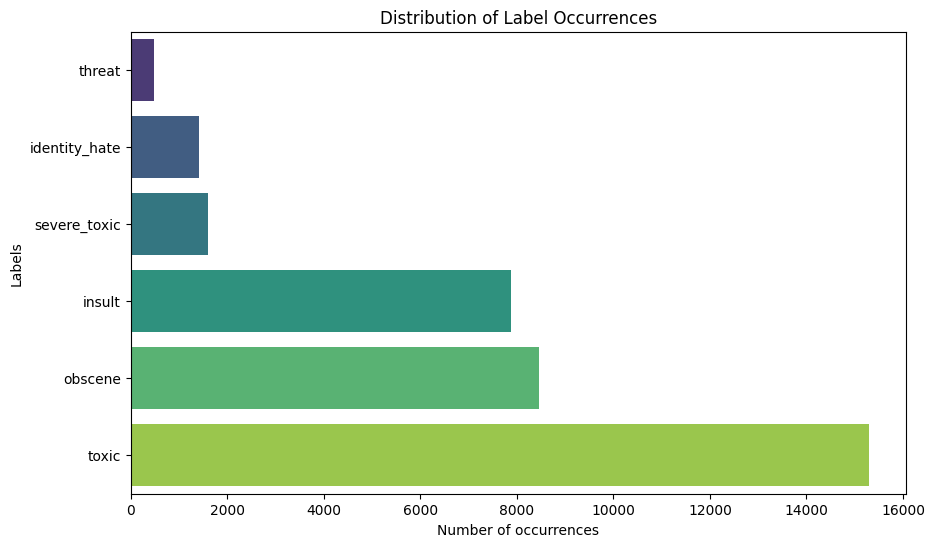

The exact values for each class are:


threat             478
identity_hate     1405
severe_toxic      1595
insult            7877
obscene           8449
toxic            15294
dtype: int64

In [35]:
# Count the occurencies of each labels.
labels = df.columns.tolist()[2:]
counts = df[labels].sum().sort_values()

# Creating an horizontal bar graph.
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=counts.values, y=counts.index, palette='viridis')

# Adding labels and title to the graph.
plt.xlabel('Number of occurrences')
plt.ylabel('Labels')
plt.title('Distribution of Label Occurrences')

# Show graph
plt.show()
print(f"The exact values for each class are:")
df[labels].sum().sort_values()

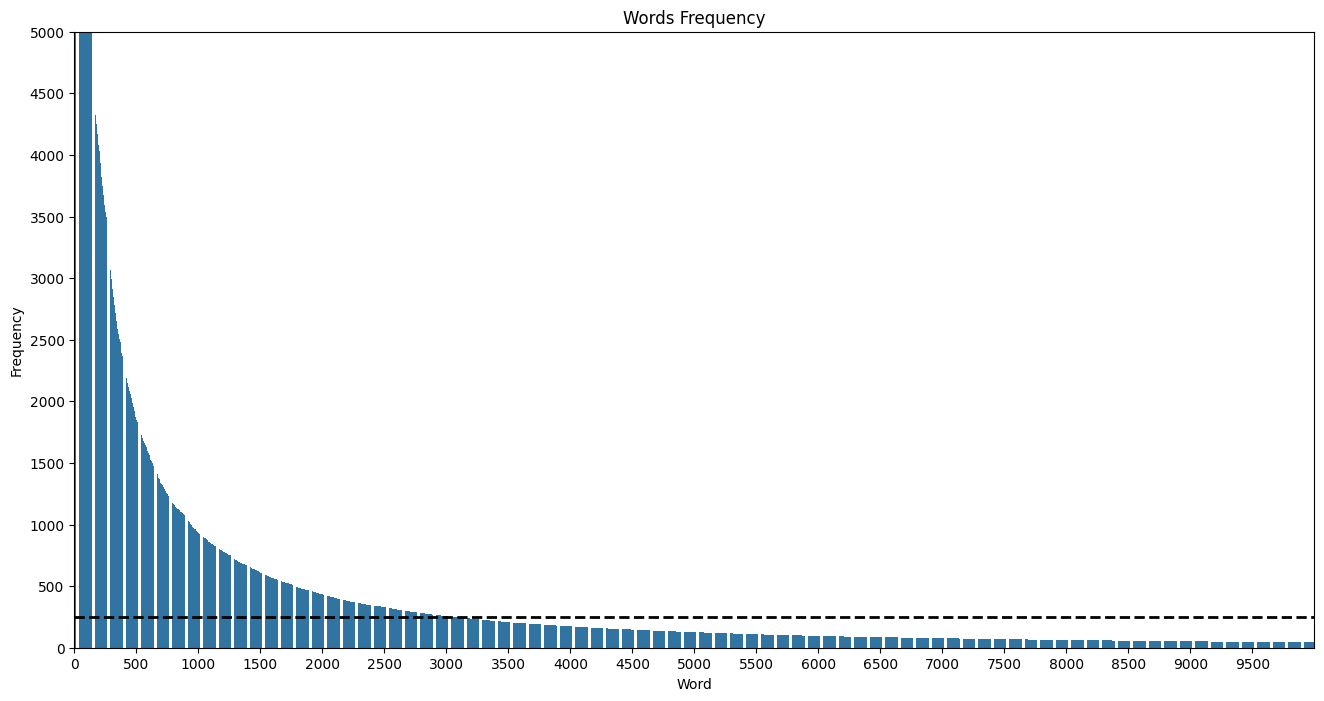

In [36]:
words = [word for comment in X for word in comment.split()]
word_counts = Counter(words)
N = 10000 # Number of words to plot.
interval = 500
top_words = word_counts.most_common(N)
words, frequencies = zip(*top_words)
plt.figure(figsize=(16, 8))
sns.barplot(x=range(len(words)), y=frequencies)
plt.title(f"Words Frequency")
plt.xlabel("Word")
plt.ylabel("Frequency")
x_labels = [f"{i * interval}" for i in range(N // interval)] # Build x-axis labels.
plt.xticks(range(0, N, interval), x_labels) # Set x-axis labels.
plt.ylim(0, 5000)  # Set y-axis limits.
plt.yticks(range(0, 5000 + 1, interval))
plt.axhline(y=250, color="black", linestyle='--', linewidth=2) # Horizontal line.
plt.show()

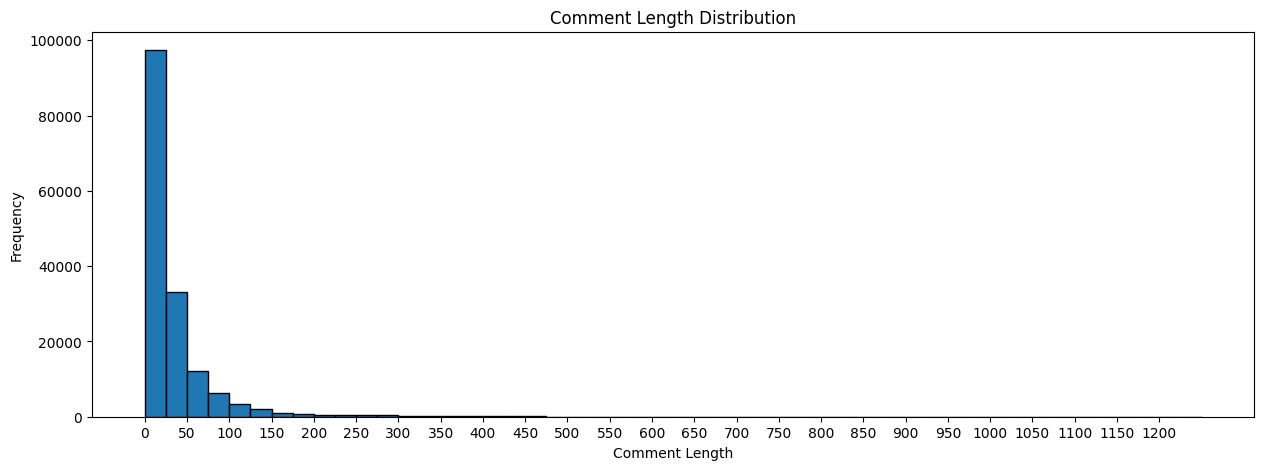

In [37]:
sentence_lengths = [len(comment.split()) for comment in X]
plt.figure(figsize=(15, 5))
plt.hist(sentence_lengths, bins=50, edgecolor="black")
plt.title("Comment Length Distribution")
plt.xlabel("Comment Length")
plt.ylabel("Frequency")
plt.xticks(range(0, 1200 + 1, 50)) # Set x-axis labels.
plt.show()

In [38]:
# Text Vectorization
MAX_FEATURES = 3000
MAX_SEQUENCE = 100
vectorizer = TextVectorization(max_tokens=MAX_FEATURES, output_sequence_length=MAX_SEQUENCE, output_mode='int')
vectorizer.adapt(X)
X = np.array(vectorizer(X))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [39]:
# Build the Neural Network.
NUM_EPOCHS = 10
BATCH_SIZE = 32

model = Sequential()

model.add(Embedding(MAX_FEATURES + 1, 32))

model.add(Bidirectional(LSTM(32, activation="tanh")))

model.add(Dense(64, activation="relu"))
model.add(Dense(64, activation="relu"))

model.add(Dense(6, activation="sigmoid"))

model.compile(loss="BinaryCrossentropy", metrics=["accuracy"], optimizer="Adam")

In [40]:
# K-FOLD CROSS VALIDATION
NUM_FOLDS = 5
KF = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=10)

print("K Cross Fold Validation START")
index = 1
for train_index, val_index in KF.split(X_train):
  print(f"Fold {index}")
  X_fold_train, X_fold_val = X_train[train_index], X_train[val_index]
  y_fold_train, y_fold_val = y_train[train_index], y_train[val_index]

  model.fit(X_fold_train, y_fold_train, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_fold_val, y_fold_val))

  scores = model.evaluate(X_fold_val, y_fold_val)
  print(f"Fold {index} => Loss: {scores[0]:.2f} and Accuracy: {scores[1]*100:.2f}%")
  index += 1
print("K Cross Fold Validation END")

K Cross Fold Validation START
Fold 1
Epoch 1/2
1995/1995 [==============================] - 81s 39ms/step - loss: 0.0813 - accuracy: 0.9927 - val_loss: 0.0618 - val_accuracy: 0.9942
Epoch 2/2
1995/1995 [==============================] - 11s 5ms/step - loss: 0.0574 - accuracy: 0.9734
Fold 1 => Loss: 0.06 and Accuracy: 97.34%
Fold 2
Epoch 1/2
1995/1995 [==============================] - 35s 17ms/step - loss: 0.0570 - accuracy: 0.9925 - val_loss: 0.0560 - val_accuracy: 0.9935
Epoch 2/2
1995/1995 [==============================] - 11s 6ms/step - loss: 0.0540 - accuracy: 0.9250
Fold 2 => Loss: 0.05 and Accuracy: 92.50%
K Cross Fold Validation END


In [41]:
# Train the model with the entire dataset.
model.fit(X_train, y_train, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE)
model.summary()

Epoch 1/2
3990/3990 [==============================] - 65s 16ms/step - loss: 0.0523 - accuracy: 0.9914
Epoch 2/2
3990/3990 [==============================] - 75s 19ms/step - loss: 0.0497 - accuracy: 0.9935
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 32)          96032     
                                                                 
 bidirectional_2 (Bidirecti  (None, 64)                16640     
 onal)                                                           
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 64)                4160      
                                                                 
 dense_8 (Dense)             (None, 6)        

In [42]:
# Calculate metrics (Precision, Recall, Accuracy)
precision = Precision()
recall = Recall()
accuracy = CategoricalAccuracy()

y_predicted = model.predict(X_test)
y_predicted = (y_predicted > 0.5).astype(int)

# Calculate metrics.
precision.update_state(y_test, y_predicted)
precision_value = precision.result().numpy()
recall.update_state(y_test, y_predicted)
recall_value = recall.result().numpy()
accuracy.update_state(y_test, y_predicted)
accuracy_value = accuracy.result().numpy()
hamming_loss_value = hamming_loss(y_test, y_predicted)
f1_value = (2 * precision_value * recall_value) / (precision_value + recall_value)

print(f"Precision: {precision_value:.2f}")
print(f"Recall:{recall_value:.2f}")
print(f"Accuracy:{accuracy_value:.2f}")
print(f"Hamming Loss: {hamming_loss_value:.2f}")
print(f"F-1 Score: {f1_value:.2f}")

998/998 [==============================] - 5s 4ms/step
Precision: 0.80
Recall:0.64
Accuracy:0.99
Hamming Loss: 0.02
F-1 Score: 0.71


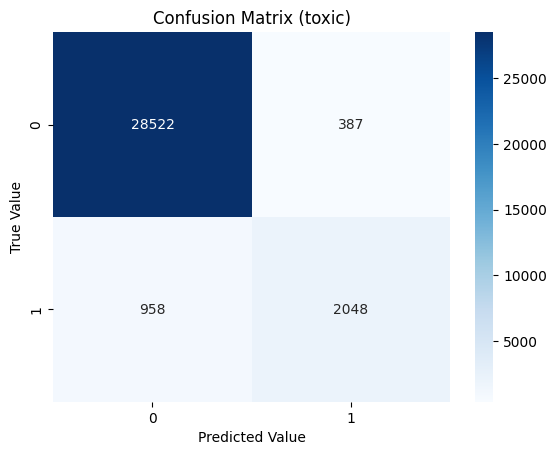

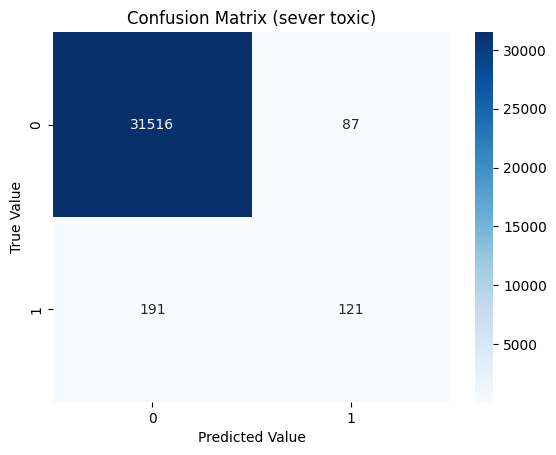

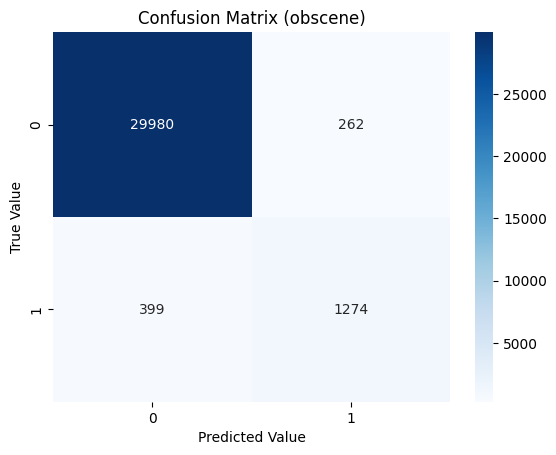

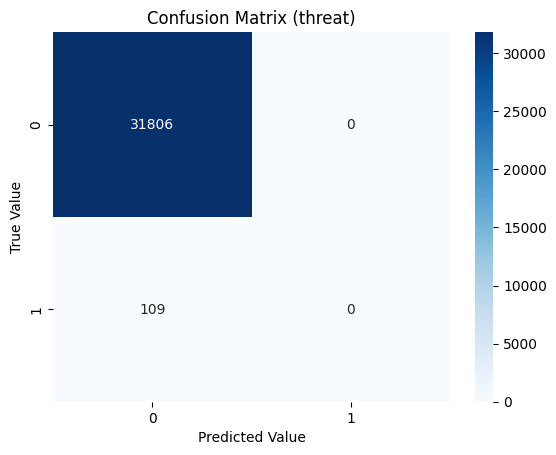

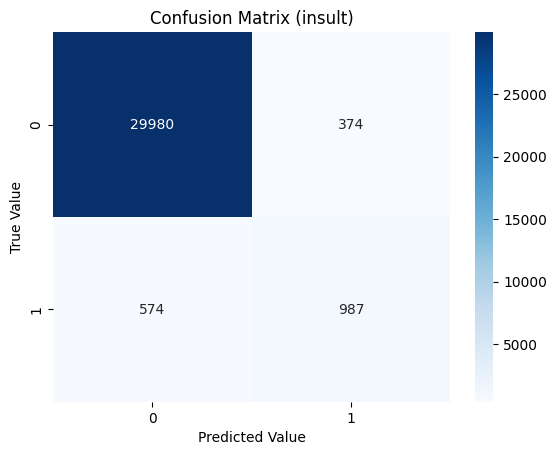

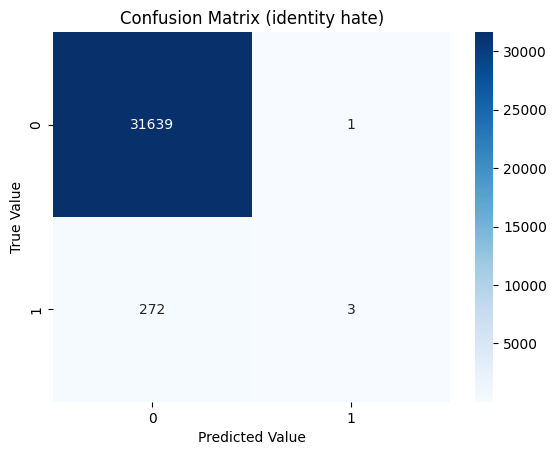

In [61]:
labels = ["toxic", "sever toxic", "obscene", "threat", "insult", "identity hate"]
for label in range(6):
  y_test_i = [row[label] for row in y_test]
  y_predicted_i = [row[label] for row in y_predicted]
  # Creating confusion matrix.
  CM = confusion_matrix(y_test_i, y_predicted_i)
  # Showing confusion matrix as a heatmap.
  sns.heatmap(CM, annot=True, fmt="d", cmap="Blues")
  plt.xlabel("Predicted Value")
  plt.ylabel("True Value")
  plt.title(f"Confusion Matrix ({labels[label]})")
  plt.show()

In [64]:
# Save the models.
model.save('toxicity.h5')
model.save('toxicity.keras')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [65]:
# Play with the model.
test = vectorizer("You are ugly!")
predict = model.predict(np.expand_dims(test, 0))
(predict > 0.5).astype(int)

1/1 [==============================] - 0s 72ms/step


array([[1, 0, 0, 0, 0, 0]])